## 📦 Step 1: Imports and Setup


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import warnings
import statsmodels.api as sm
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm          # linear models
sns.set(style="whitegrid", font_scale=1.2)


warnings.filterwarnings("ignore")
sns.set(style="whitegrid", font_scale=1.2)


## 📥 Step 2: Load & Clean Data

In [2]:
def coerce_numeric_columns(df):
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['rank', 'test records']):
            df[col] = (
                df[col]
                .astype(str)
                .str.extract(r'(\d+)')  # extract digits from strings like ' 10]' or '[1]'
                .astype(float)
            )
    return df


def load_and_clean_excel(file_path):
    df = pd.read_excel(file_path)
    df = coerce_numeric_columns(df)
    return df



def plot_correlation(data):
    g = sns.lmplot(
        data=data,
        x="records_in_cluster",
        y="rank",
        hue="method",
        col="company",
        col_wrap=4,
        height=4,
        aspect=1,
        scatter_kws={"s": 30, "alpha": 0.7},
        line_kws={"lw": 2},
        ci=None
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Records in Cluster", "Rank (lower = better)")
    g.fig.suptitle("Rank vs. Cluster Size per Company", y=1.03, fontsize=18)
    plt.tight_layout()
    plt.show()

def compute_rank_correlation(data):
    stats = []
    for (company, method), group in data.groupby(["company", "method"]):
        if len(group.dropna()) < 3:
            continue
        r_spear, _ = spearmanr(group['records_in_cluster'], group['rank'])
        r_pear, _ = pearsonr(group['records_in_cluster'], group['rank'])
        stats.append({
            'company': company,
            'method': method,
            'pearson_corr': round(r_pear, 3),
            'spearman_corr': round(r_spear, 3),
            'n_samples': len(group)
        })
    return pd.DataFrame(stats).sort_values(by='spearman_corr', ascending=False)

def analyze_excel(file_path):
    companies = ['Adobe', 'Amazon', 'Apple', 'Facebook', 'Google', 'IBM',
                 'Microsoft', 'Nvidia', 'Oracle', 'Salesforce', 'Tesla',
                 'Twitter', 'Uber']
    df_raw = load_and_clean_excel(file_path)
    df_long = reshape_company_data(df_raw, companies)
    print("📉 Showing correlation plot...")
    plot_correlation(df_long)
    print("\n📊 Rank Sensitivity Analysis (Correlation Table):")
    correlation_df = compute_rank_correlation(df_long)
    display(correlation_df)
    return df_long, correlation_df


## 🔁 Step 3: Reshape to Long Format



In [3]:
import re

def fuzzy_match_column(columns, pattern):
    regex = re.compile(pattern, re.IGNORECASE)
    matches = [col for col in columns if regex.search(col)]
    return matches[0] if matches else None

def reshape_company_data(df, companies):
    records = []

    for company in companies:
        for method in ['Multiclustering', 'Standard']:
            suffix = "" if method == "Multiclustering" else r"\.1"

            rank_pattern = fr"{company} Rank{suffix}"
            cluster_pattern = fr"Test.*cluster.*{company}{suffix}"

            rank_col = fuzzy_match_column(df.columns, rank_pattern)
            cluster_col = fuzzy_match_column(df.columns, cluster_pattern)

            if not rank_col or not cluster_col:
                print(f"⚠️ Missing columns for {company} - {method}")
                continue

            for idx, row in df.iterrows():
                records.append({
                    'query': row['Query'],
                    'company': company,
                    'rank': row.get(rank_col, np.nan),
                    'records_in_cluster': row.get(cluster_col, np.nan),
                    'method': method
                })

    return pd.DataFrame(records)


## 📊 Step 4: Correlation + Scatter with Regression

## 📈 Step 5: Compute Rank Sensitivity Statistics

In [4]:
def compute_rank_correlation(data):
    stats = []

    for (company, method), group in data.groupby(["company", "method"]):
        valid_group = group.dropna(subset=["records_in_cluster", "rank"])
        print(f"Company: {company}, Method: {method}, Valid Samples: {len(valid_group)}")
        
        if len(valid_group) < 3:
            print("  ➤ Skipping due to insufficient data.")
            continue

        try:
            r_spear, _ = spearmanr(valid_group['records_in_cluster'], valid_group['rank'])
            r_pear, _ = pearsonr(valid_group['records_in_cluster'], valid_group['rank'])
            stats.append({
                'company': company,
                'method': method,
                'pearson_corr': round(r_pear, 3),
                'spearman_corr': round(r_spear, 3),
                'n_samples': len(valid_group)
            })
        except Exception as e:
            print(f"  ⚠️ Error computing correlation: {e}")

    if not stats:
        print("\n⚠️ No correlations could be computed. Check if the data is missing or columns are named differently.")
    else:
        return pd.DataFrame(stats).sort_values(by='spearman_corr', ascending=False)


## 🧠 Step 6: Full Pipeline Runner

In [5]:
def compute_rank_correlation(data):
    stats = []

    for (company, method), group in data.groupby(["company", "method"]):
        valid_group = group.dropna(subset=["records_in_cluster", "rank"])
        print(f"\n📌 Company: {company}, Method: {method}, Valid Samples: {len(valid_group)}")

        if len(valid_group) < 3:
            print("  ➤ Skipping (not enough data)")
            continue

        try:
            r_spear, _ = spearmanr(valid_group['records_in_cluster'], valid_group['rank'])
            r_pear, _ = pearsonr(valid_group['records_in_cluster'], valid_group['rank'])
            print(f"  ✅ Spearman: {r_spear:.3f}, Pearson: {r_pear:.3f}")
            stats.append({
                'company': company,
                'method': method,
                'pearson_corr': round(r_pear, 3),
                'spearman_corr': round(r_spear, 3),
                'n_samples': len(valid_group)
            })
        except Exception as e:
            print(f"  ⚠️ Error computing correlation: {e}")

    if stats:
        return pd.DataFrame(stats).sort_values(by='spearman_corr', ascending=False)
    else:
        print("\n🚫 No valid correlations computed — possibly all data is missing or malformed.")
        return pd.DataFrame()


## ✅ Usage

📉 Showing correlation plot...


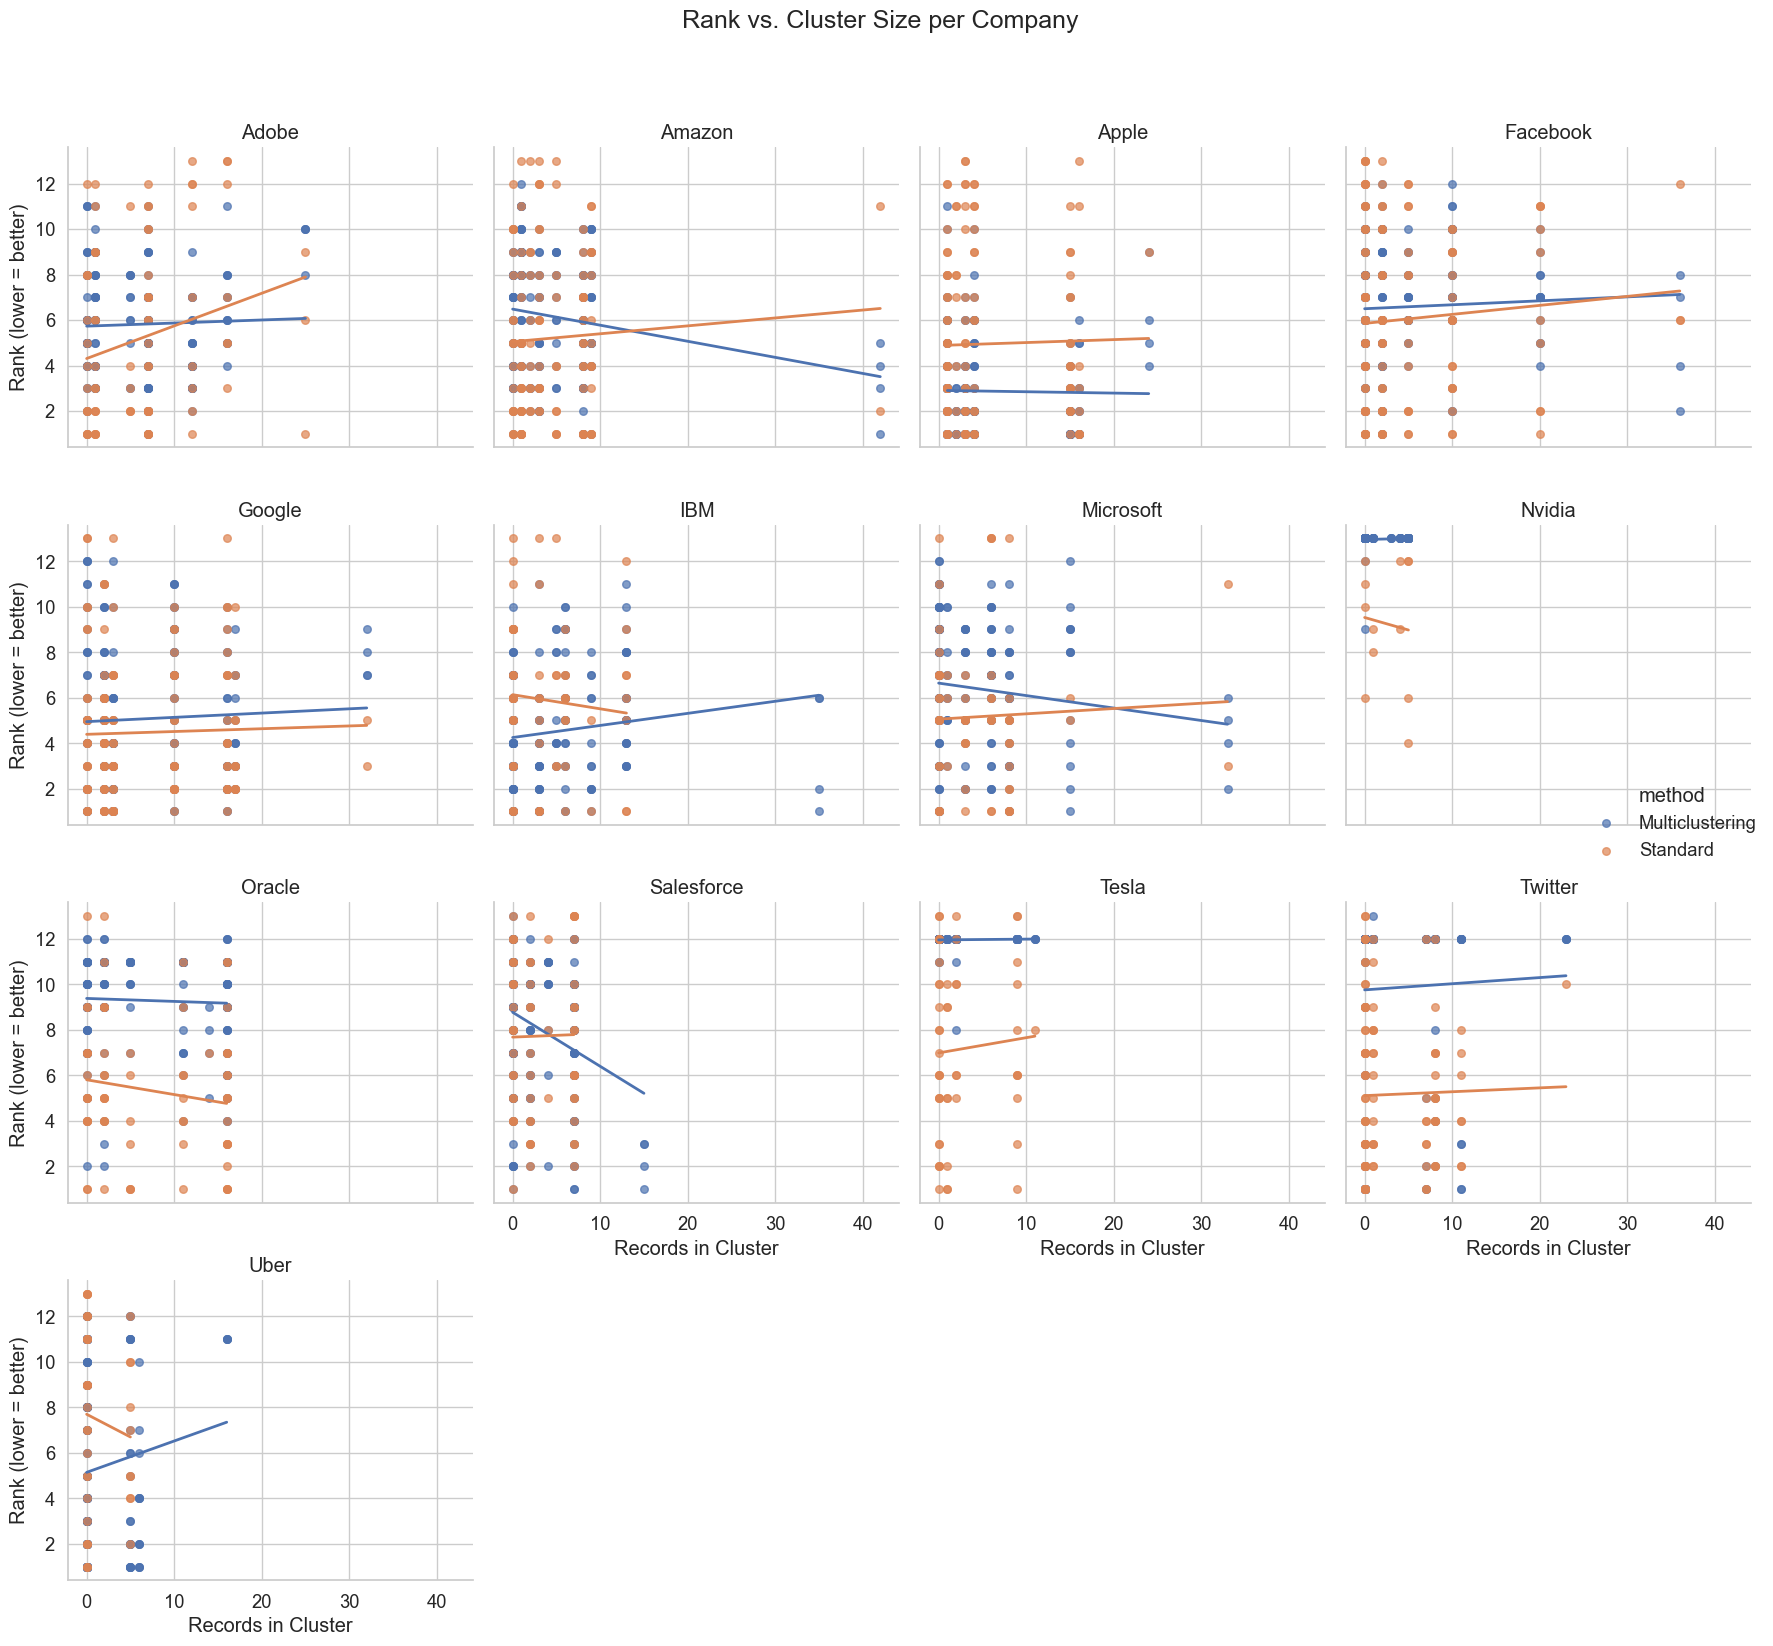


📊 Rank Sensitivity Analysis (Correlation Table):

📌 Company: Adobe, Method: Multiclustering, Valid Samples: 184
  ✅ Spearman: -0.042, Pearson: 0.033

📌 Company: Adobe, Method: Standard, Valid Samples: 84
  ✅ Spearman: 0.229, Pearson: 0.224

📌 Company: Amazon, Method: Multiclustering, Valid Samples: 184
  ✅ Spearman: -0.072, Pearson: -0.177

📌 Company: Amazon, Method: Standard, Valid Samples: 128
  ✅ Spearman: 0.061, Pearson: 0.057

📌 Company: Apple, Method: Multiclustering, Valid Samples: 184
  ✅ Spearman: -0.103, Pearson: -0.017

📌 Company: Apple, Method: Standard, Valid Samples: 119
  ✅ Spearman: 0.061, Pearson: 0.020

📌 Company: Facebook, Method: Multiclustering, Valid Samples: 184
  ✅ Spearman: 0.145, Pearson: 0.051

📌 Company: Facebook, Method: Standard, Valid Samples: 139
  ✅ Spearman: 0.042, Pearson: 0.077

📌 Company: Google, Method: Multiclustering, Valid Samples: 184
  ✅ Spearman: -0.013, Pearson: 0.045

📌 Company: Google, Method: Standard, Valid Samples: 150
  ✅ Spearman: 0.

company           method  pearson_corr  spearman_corr  n_samples
1        Adobe         Standard         0.224          0.229         84
10         IBM  Multiclustering         0.139          0.189        184
6     Facebook  Multiclustering         0.051          0.145        184
22     Twitter  Multiclustering         0.032          0.100        184
14      Nvidia  Multiclustering         0.075          0.091        184
23     Twitter         Standard         0.021          0.089        112
21       Tesla         Standard         0.067          0.070         51
5        Apple         Standard         0.020          0.061        119
3       Amazon         Standard         0.057          0.061        128
16      Oracle  Multiclustering        -0.040          0.045        184
7     Facebook         Standard         0.077          0.042        139
20       Tesla  Multiclustering         0.039          0.032        184
24        Uber  Multiclustering         0.105          0.017        184
9       Google         Standard         0.028          0.003        150
8       Google  Multiclustering         0.045         -0.013        184
19  Salesforce         Standard         0.014         -0.015         62
0        Adobe  Multiclustering         0.033         -0.042        184
15      Nvidia         Standard        -0.092         -0.056         12
2       Amazon  Multiclustering        -0.177         -0.072        184
4        Apple  Multiclustering        -0.017         -0.103        184
11         IBM         Standard        -0.081         -0.114         68
12   Microsoft  Multiclustering        -0.121         -0.117        184
25        Uber         Standard        -0.111         -0.123         40
13   Microsoft         Standard         0.045         -0.133         68
17      Oracle         Standard        -0.146         -0.170         73
18  Salesforce  Multiclustering        -0.281         -0.237        184

In [6]:
file_path = r"C:\Users\adler\OneDrive\Talent.AI\TalentAI-research-yasmin\final_measurements\unbiasing\for_company_size\with_gender_and_age_list_frequency_unbiasing_per_cluster.xlsx"
long_df, correlation_df = analyze_excel(file_path)


In [7]:
def plot_average_ranks(data, sort_by='Multiclustering'):
    # ── compute means ─────────────────────────────────────────────────────────
    avg = (data.dropna(subset=['rank'])
                 .groupby(['company', 'method'])['rank']
                 .mean()
                 .unstack())          # columns → methods, rows → companies

    # ── sort companies by the chosen column so bars appear ordered ───────────
    avg = avg.sort_values(by=sort_by)

    # ── long‑form for seaborn ────────────────────────────────────────────────
    avg_long = avg.reset_index().melt(id_vars='company',
                                      var_name='method',
                                      value_name='avg_rank')

    # ── plot ─────────────────────────────────────────────────────────────────
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=avg_long,
                     x='company', y='avg_rank', hue='method',
                     palette='Set2')
    ax.set_title('Average Rank per Company')
    ax.set_ylabel('Average Rank  (lower = better)')
    ax.set_xlabel('')
    plt.xticks(rotation=45, ha='right')

    # annotate each bar with its value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()


In [8]:
def plot_correlation_strength(corr_df):
    if corr_df.empty:
        print('🚫  No correlation data.')
        return

    # order by absolute correlation so most “interesting” companies pop first
    corr_df['abs_ρ'] = corr_df['spearman_corr'].abs()
    corr_df = corr_df.sort_values('abs_ρ', ascending=False)

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=corr_df,
                     x='company', y='spearman_corr', hue='method',
                     palette='Spectral')
    plt.axhline(0, color='gray', ls='--')
    ax.set_ylabel('Spearman ρ  (±1)')
    ax.set_xlabel('')
    ax.set_title('Impact of Cluster Size on Rank\n(ρ > 0 ⇒ more records → worse rank)')
    plt.xticks(rotation=45, ha='right')

    # annotate ρ on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():+.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_rank_distributions(data):
    plt.figure(figsize=(14, 6))
    ax = sns.boxplot(data=data, x='company', y='rank', hue='method',
                     palette='Paired', showmeans=True,
                     meanprops={'marker':'o',
                                'markeredgecolor':'black',
                                'markerfacecolor':'white'})
    ax.set_ylabel('Rank  (lower = better)')
    ax.set_xlabel('')
    ax.set_title('Rank Distribution per Company')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [10]:
def plot_rank_delta(data):
    mean_ranks = (data.dropna(subset=['rank'])
                        .groupby(['company','method'])['rank']
                        .mean()
                        .unstack())       # cols = methods
    mean_ranks['Δ'] = mean_ranks['Standard'] - mean_ranks['Multiclustering']
    mean_ranks = mean_ranks.sort_values('Δ')

    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x=mean_ranks.index, y=mean_ranks['Δ'],
                     palette='coolwarm_r')
    plt.axhline(0, color='gray', ls='--')
    ax.set_ylabel('Avg Rank Δ  (Standard – Multi)')
    ax.set_title('Average Rank Gain (negative = Multiclustering better)')
    plt.xticks(rotation=45, ha='right')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():+.2f}',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()


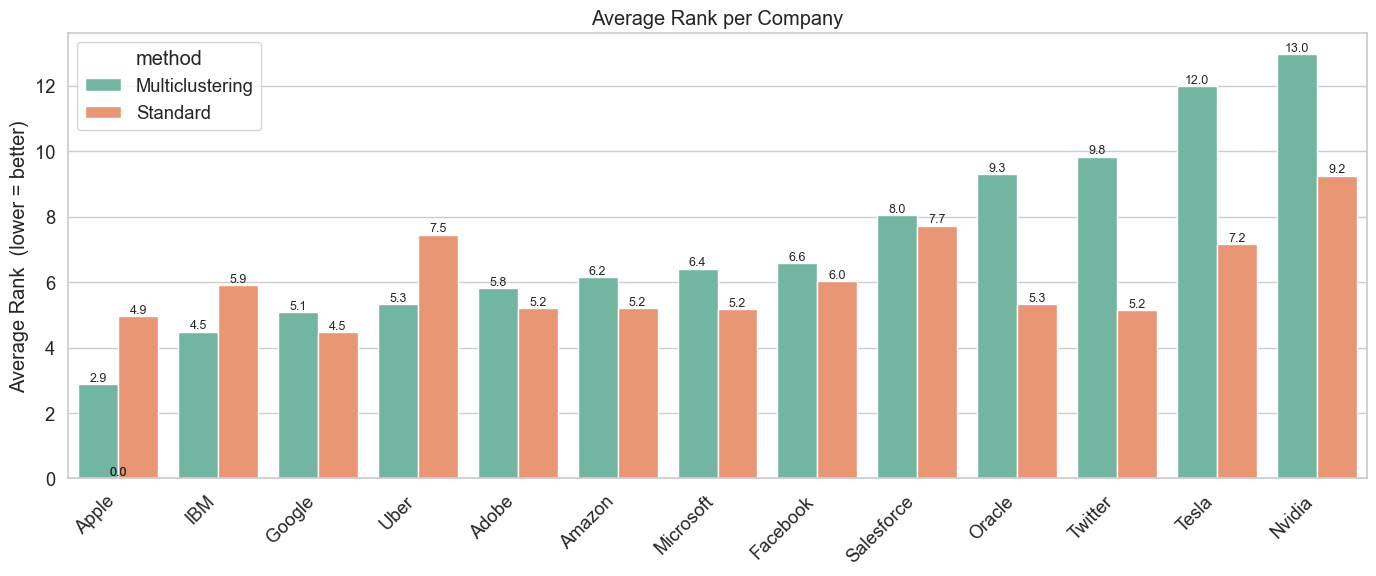

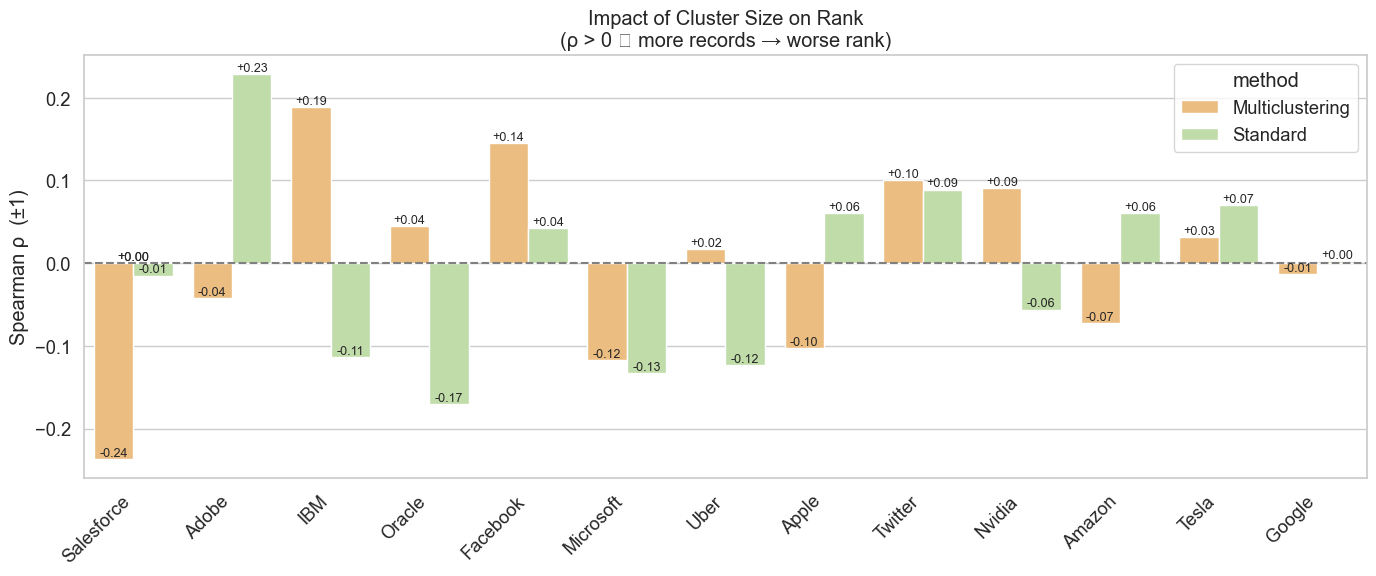

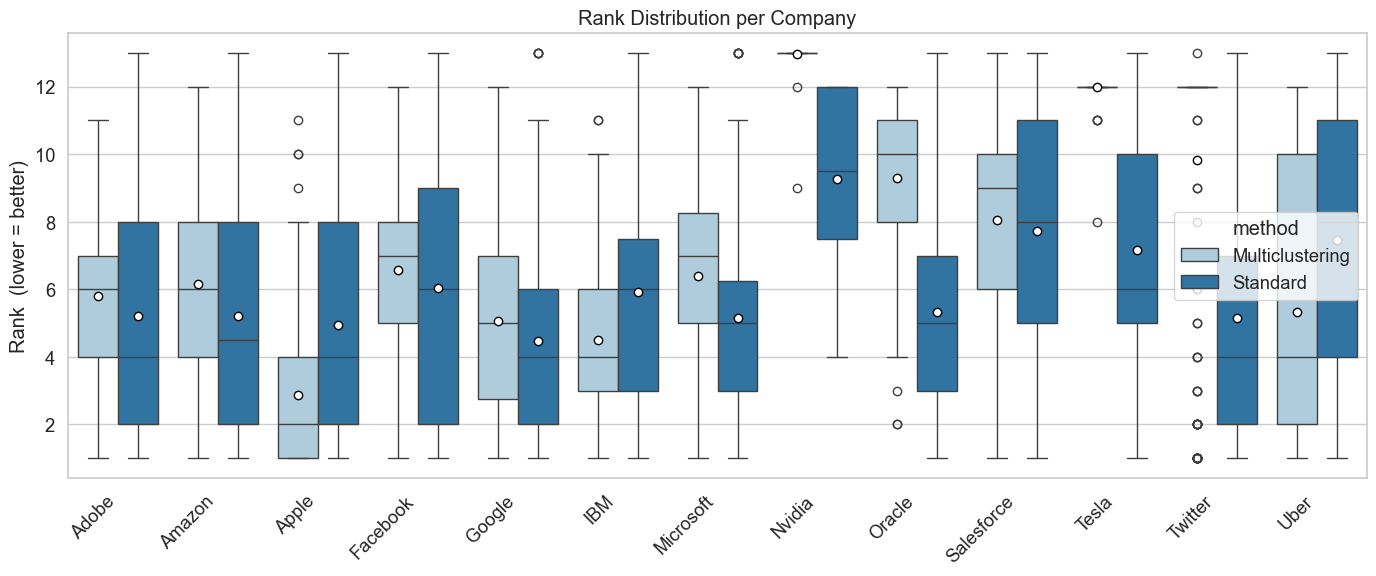

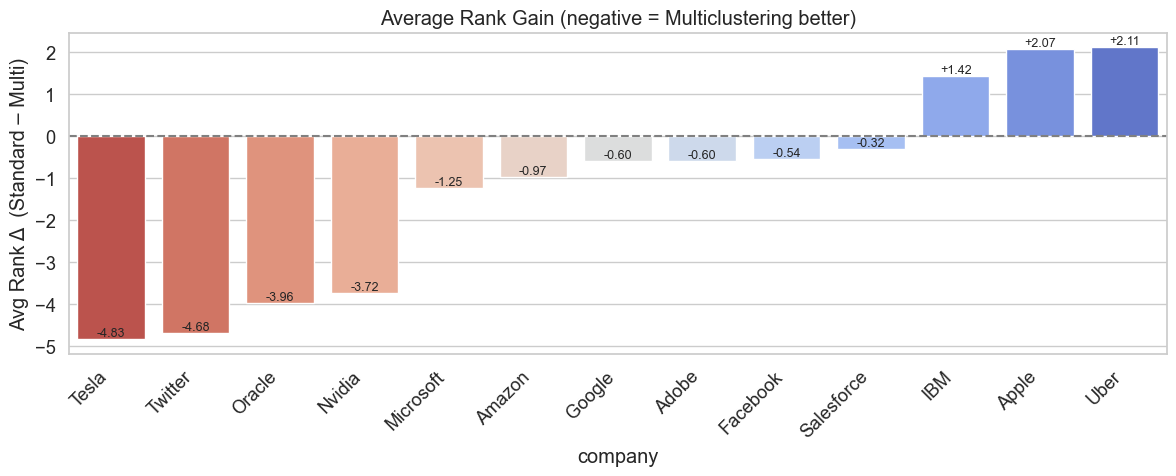

In [11]:
plot_average_ranks(long_df)
plot_correlation_strength(correlation_df)
plot_rank_distributions(long_df)
plot_rank_delta(long_df)          # optional


In [12]:
def compute_slope_table(long_df, min_points=5):
    """
    Fit Rank = β0 + β1 * Records  (OLS)
    Returns a DataFrame with β1 per company & method.
    """
    out = []
    for (cmp, mth), g in long_df.groupby(['company', 'method']):
        g = g.dropna(subset=['records_in_cluster', 'rank'])
        if len(g) < min_points:
            continue                       # not enough data
        X = sm.add_constant(g['records_in_cluster'])
        model = sm.OLS(g['rank'], X).fit()
        out.append({
            'company': cmp,
            'method' : mth,
            'slope'  : model.params[1],    # β1
            'pvalue' : model.pvalues[1],
            'n'      : len(g)
        })
    return pd.DataFrame(out)


In [13]:
def plot_slope_bars(slope_df):
    if slope_df.empty:
        print("🚫  No slope data.")
        return
    
    # sort so most negative (strong effect) on one side
    slope_df = slope_df.sort_values('slope')
    
    plt.figure(figsize=(14,6))
    ax = sns.barplot(data=slope_df,
                     x='company', y='slope', hue='method',
                     palette='coolwarm')
    
    ax.axhline(0, color='gray', ls='--')
    ax.set_ylabel('OLS slope  β₁  (records → rank)')
    ax.set_xlabel('')
    ax.set_title('Effect of Cluster Size on Rank')
    plt.xticks(rotation=45, ha='right')
    
    # annotate slope & significance
    for p in ax.patches:
        cmp = p.get_x() + p.get_width()/2
        val = p.get_height()
        ax.annotate(f'{val:+.2f}',
                    (cmp, val),
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()


company           method     slope    pvalue    n
0   Adobe  Multiclustering  0.013556  0.652354  184
1   Adobe         Standard  0.143465  0.040529   84
2  Amazon  Multiclustering -0.070717  0.016082  184
3  Amazon         Standard  0.034784  0.525890  128
4   Apple  Multiclustering -0.005939  0.813920  184

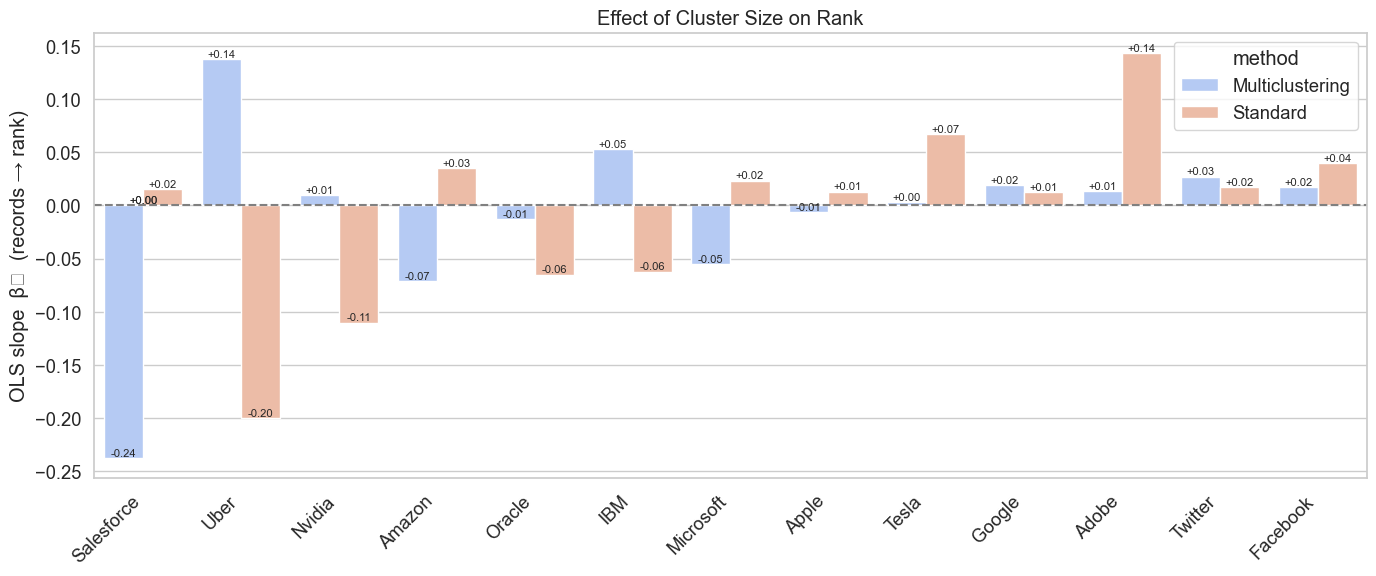

In [14]:
slope_df = compute_slope_table(long_df)
display(slope_df.head())          # optional table
plot_slope_bars(slope_df)


In [15]:
def paired_slope_plot(long_df, min_pts=5):
    rows = []
    for (cmp, mth), g in long_df.groupby(['company', 'method']):
        g = g.dropna(subset=['records_in_cluster', 'rank'])
        if len(g) < min_pts: continue
        X = sm.add_constant(g['records_in_cluster'])
        β1 = sm.OLS(g['rank'], X).fit().params[1]
        rows.append({'company': cmp, 'method': mth, 'slope': β1})
    slope = pd.DataFrame(rows).pivot(index='company', columns='method', values='slope')
    slope = slope.dropna().sort_values('Standard')               # order by Std

    fig, ax = plt.subplots(figsize=(10, 6))
    y = np.arange(len(slope))
    ax.hlines(y, slope['Multiclustering'], slope['Standard'], color='gray', alpha=.4)
    ax.scatter(slope['Multiclustering'], y, label='Multiclustering', color='#1f77b4', s=80)
    ax.scatter(slope['Standard'],        y, label='Standard',        color='#d62728', s=80)
    ax.axvline(0, color='black', lw=.8)
    ax.set_yticks(y)
    ax.set_yticklabels(slope.index)
    ax.set_xlabel('OLS slope  β₁  (records → rank)')
    ax.set_title('Effect of Cluster Size on Rank (per company)')
    ax.legend()
    plt.tight_layout(); plt.show()


In [16]:
def heatmap_delta(long_df, n_bins=4):
    df = long_df.dropna(subset=['rank','records_in_cluster'])
    df['rec_bin'] = pd.qcut(df['records_in_cluster'], q=n_bins, duplicates='drop')
    pivot = (df.pivot_table(index='company', columns=['rec_bin','method'],
                            values='rank', aggfunc='mean'))
    # compute Δ = Std – Multi for each bin
    delta = pivot.xs('Standard', level='method', axis=1) - \
            pivot.xs('Multiclustering', level='method', axis=1)
    plt.figure(figsize=(12,6))
    sns.heatmap(delta, annot=True, cmap='coolwarm', center=0, linewidths=.5,
                fmt='.1f', cbar_kws={'label':'Rank Δ  (Std – Multi)'})
    plt.title('Avg Rank Difference\n(negative ⇒ Multiclustering better)')
    plt.xlabel('Records‑in‑cluster quantile')
    plt.ylabel('')
    plt.tight_layout(); plt.show()


In [17]:
import plotly.express as px

def interactive_scatter(long_df, company=None):
    d = long_df if company is None else long_df[long_df['company']==company]
    fig = px.scatter(d, x='records_in_cluster', y='rank',
                     color='method', facet_col='company' if company is None else None,
                     hover_data=['query'],
                     height=400, width=1000, trendline='ols',
                     labels={'records_in_cluster':'Records in Cluster',
                             'rank':'Rank (lower = better)'} )
    fig.update_layout(title_text='Records vs Rank (interactive)')
    fig.show()


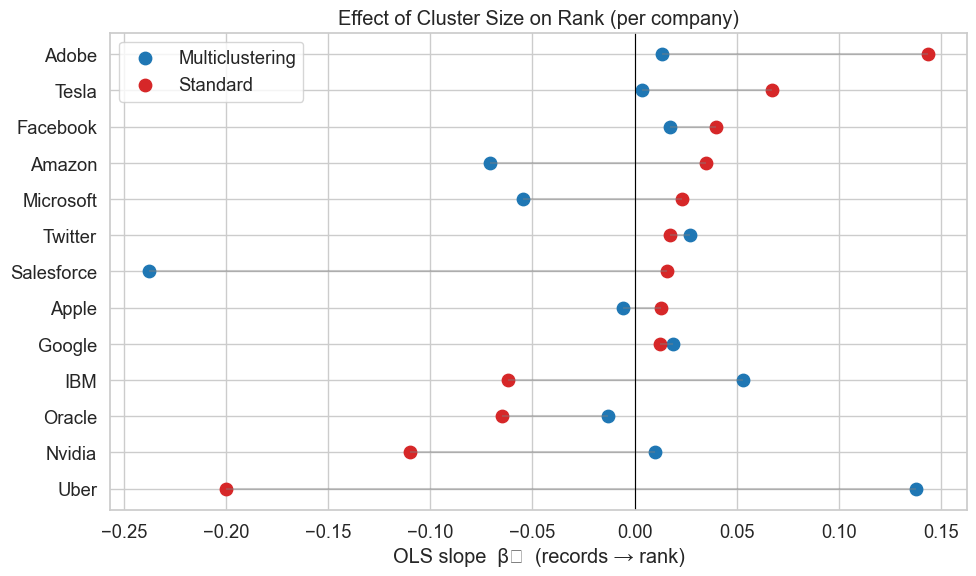

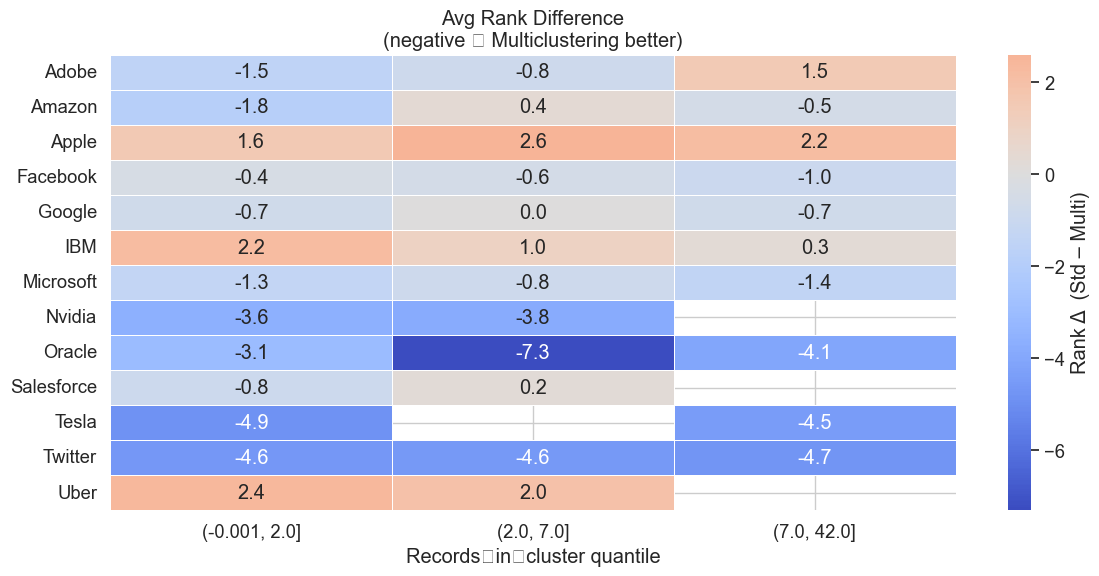

In [18]:
# after you already have `long_df`
paired_slope_plot(long_df)
heatmap_delta(long_df, n_bins=4)
interactive_scatter(long_df)             # entire set
# interactive_scatter(long_df, 'Google')  # single company


In [28]:
import pandas as pd

# --- 1. Put your Nearest Cluster numbers here (exactly as they appear, in order) ---
nearest_clusters = [
    5, 3, 6, 5, 0, 3, 3, 4, 3, 4, 7, 4, 4, 6, 3, 5, 4, 5, 5, 0, 0, 4, 5, 5, 3,
    7, 0, 7, 5, 4, 0, 7, 7, 7, 2, 6, 5, 4, 0, 6, 2, 3, 0, 3, 3, 5, 7, 3, 3, 2,
    2, 5, 5, 0, 4, 1, 3, 7, 0, 2, 7, 1, 4, 0, 0, 0, 7, 3, 7, 0, 5, 7, 7, 3, 4,
    5, 5, 4, 4, 0, 0, 4, 0, 3, 0, 0, 4, 7, 7, 0, 4, 5, 3, 5, 0, 5, 2, 7, 0, 3,
    2, 5, 4, 7, 3, 5, 5, 4, 7, 2, 3, 7, 1, 0, 6, 5, 6, 0, 3, 0, 0, 5, 4, 5, 3,
    5, 4, 6, 5, 5, 5, 5, 1, 5, 5, 5, 4, 5, 3, 6, 5, 3, 3, 4, 3, 3, 3, 2, 6, 0,
    2, 5, 5, 5, 6, 0, 2, 0, 0, 0, 0, 2, 3, 7, 6, 3, 3, 5, 2, 0, 3, 0, 0, 5, 5,
    5, 0, 4, 0, 5, 5, 3, 7, 7
]

# --- 2. Define the fixed mapping Nearest Cluster → Total Records in Cluster ---
cluster_size = {
    0: 4,
    1: 309,
    2: 148,
    3: 70,
    4: 128,
    5: 6,
    6: 32,
    7: 37,
}

# --- 3. Build a DataFrame and apply the mapping ---
df = pd.DataFrame({'Nearest Cluster': nearest_clusters})
df['Total Records in Cluster'] = df['Nearest Cluster'].map(cluster_size)

# print(df['Total Records in Cluster'])
# --- 4. (Optional) inspect or save ---
# print(df)       # quick peek
# df.to_csv('cluster_table.csv', index=False)
# pd.set_option('display.max_rows', None)
print(df['Total Records in Cluster'].to_string(index=False))




  6
 70
 32
  6
  4
 70
 70
128
 70
128
 37
128
128
 32
 70
  6
128
  6
  6
  4
  4
128
  6
  6
 70
 37
  4
 37
  6
128
  4
 37
 37
 37
148
 32
  6
128
  4
 32
148
 70
  4
 70
 70
  6
 37
 70
 70
148
148
  6
  6
  4
128
309
 70
 37
  4
148
 37
309
128
  4
  4
  4
 37
 70
 37
  4
  6
 37
 37
 70
128
  6
  6
128
128
  4
  4
128
  4
 70
  4
  4
128
 37
 37
  4
128
  6
 70
  6
  4
  6
148
 37
  4
 70
148
  6
128
 37
 70
  6
  6
128
 37
148
 70
 37
309
  4
 32
  6
 32
  4
 70
  4
  4
  6
128
  6
 70
  6
128
 32
  6
  6
  6
  6
309
  6
  6
  6
128
  6
 70
 32
  6
 70
 70
128
 70
 70
 70
148
 32
  4
148
  6
  6
  6
 32
  4
148
  4
  4
  4
  4
148
 70
 37
 32
 70
 70
  6
148
  4
 70
  4
  4
  6
  6
  6
  4
128
  4
  6
  6
 70
 37
 37
